In [69]:
package SyringeSystem {
    import ISQ::*;
    package Library{
        import Ports::*;
        import ExternalSystems::*;
        import PartDefs::*;
        import Actors::*;
        import ActionDefs::*;
        package Ports {
            item def Fluid;
            port def Hand {
                inout force;
            }
            port def ExtLuer{
                inout item fluid:Fluid;
            }
            port def PierceSite{
                inout item fluid:Fluid;
            }
            port def Cannula{
                inout item fluid:Fluid;
            }
            interface def PiercingInterface{
                flow of Fluid
                    from pierceSite.fluid to cannula.fluid;
                flow of Fluid
                    from cannula.fluid to pierceSite.fluid;
                end pierceSite : PierceSite;
                end cannula: Cannula;
            }
            interface def LuerInterface{
                flow of Fluid
                    from ExtPort.fluid to IntPort.fluid;
                flow of Fluid
                    from IntPort.fluid to ExtPort.fluid;
                end ExtPort : ExtLuer;
                end IntPort: ~ExtLuer;
            }
        }
        package ExternalSystems{
            item def Vial{
                port septum{
                    inout fluid:Fluid;
                }
                item drug:Fluid;
            }
            item def SharpsBin;
            item def Storage;
            item def Needle{
                port Luer: ~ExtLuer;
                port Cannula{
                    inout fluid:Fluid;
                }
            }
        }
        package PartDefs{
            part def Syringe{
                port Handle;
                port NeedleAttachment : ExtLuer;
                
            }
        }
        package ActionDefs{
            action TreatPatient {
                action UnpackageSyringe{}
                then event occurrence Unpackaged;
                then action AssembleNeedle{}
                then event occurrence NeedleAttached;
                then action FillDrug{}
                then event occurrence SyringeFilled;
                then action InsertCannula{}
                then event occurrence CannulaInserted;
                then action DeliverDrug{}
                then event occurrence SyringeEmptied;
                then event occurrence PatientTreated;
            }
        }
        package Actors{
            part def Human;
            part def HCP :> Human{
                port hand[2];
            }
            part def Patient :> Human{
                port injectionSite : PierceSite;
            }
        }
    }
    package Structure{
        import Library::*;
        part syringe: Syringe{
            part plunger{
                port 'Seal Mount';
                port 'Thumb Pad';
            }
            part barrel{
                port 'Finger Pad';
                port 'Internal Bore';
                port 'Needle Attachment': ExtLuer;
            }
            part 'plunger seal'{
                port 'Plunger Surface';
                port 'Sealing Surface';
            }
            bind barrel.'Needle Attachment' = NeedleAttachment;
            bind barrel.'Finger Pad' = Handle;
            bind plunger.'Thumb Pad' = Handle;
            connect plunger.'Seal Mount' to 'plunger seal'.'Plunger Surface';
            connect barrel.'Internal Bore' to 'plunger seal'.'Sealing Surface';
        }
    }
    package TreatmentContext{
        part TreatmentContext{
            perform TreatPatient;
            import Library::*;
            part syringe: Syringe{
                event TreatPatient.Unpackaged;
                event TreatPatient.NeedleAttached;
                event TreatPatient.SyringeFilled;
                event TreatPatient.SyringeEmptied;
            }
            timeslice storage = start;
            then timeslice inUse{
                interface : LuerInterface connect
                    ExtPort ::> syringe.NeedleAttachment to 
                    IntPort ::> needle.Luer;
                part vial:Vial;
                part needle:Needle;
                part hcp: HCP{
                    perform TreatPatient.AssembleNeedle;
                    perform TreatPatient.FillDrug;
                    perform TreatPatient.InsertCannula;
                    perform TreatPatient.DeliverDrug;
                }
                part patient:Patient{
                    event TreatPatient.CannulaInserted;
                    event TreatPatient.PatientTreated;
                }
                timeslice filling = start{
                    interface : PiercingInterface connect
                        cannula ::>needle.Cannula to 
                        pierceSite ::> vial.septum;
                }
                then timeslice delivery{
                    interface : PiercingInterface connect
                        cannula ::>needle.Cannula to 
                        pierceSite ::> patient.injectionSite;
                }
            }
            then timeslice disposed = done{
                part sharpsBin : SharpsBin;
            }
        }
    }
}

Package SyringeSystem (74156fbe-c520-4266-95e1-f0dec06d06c7)


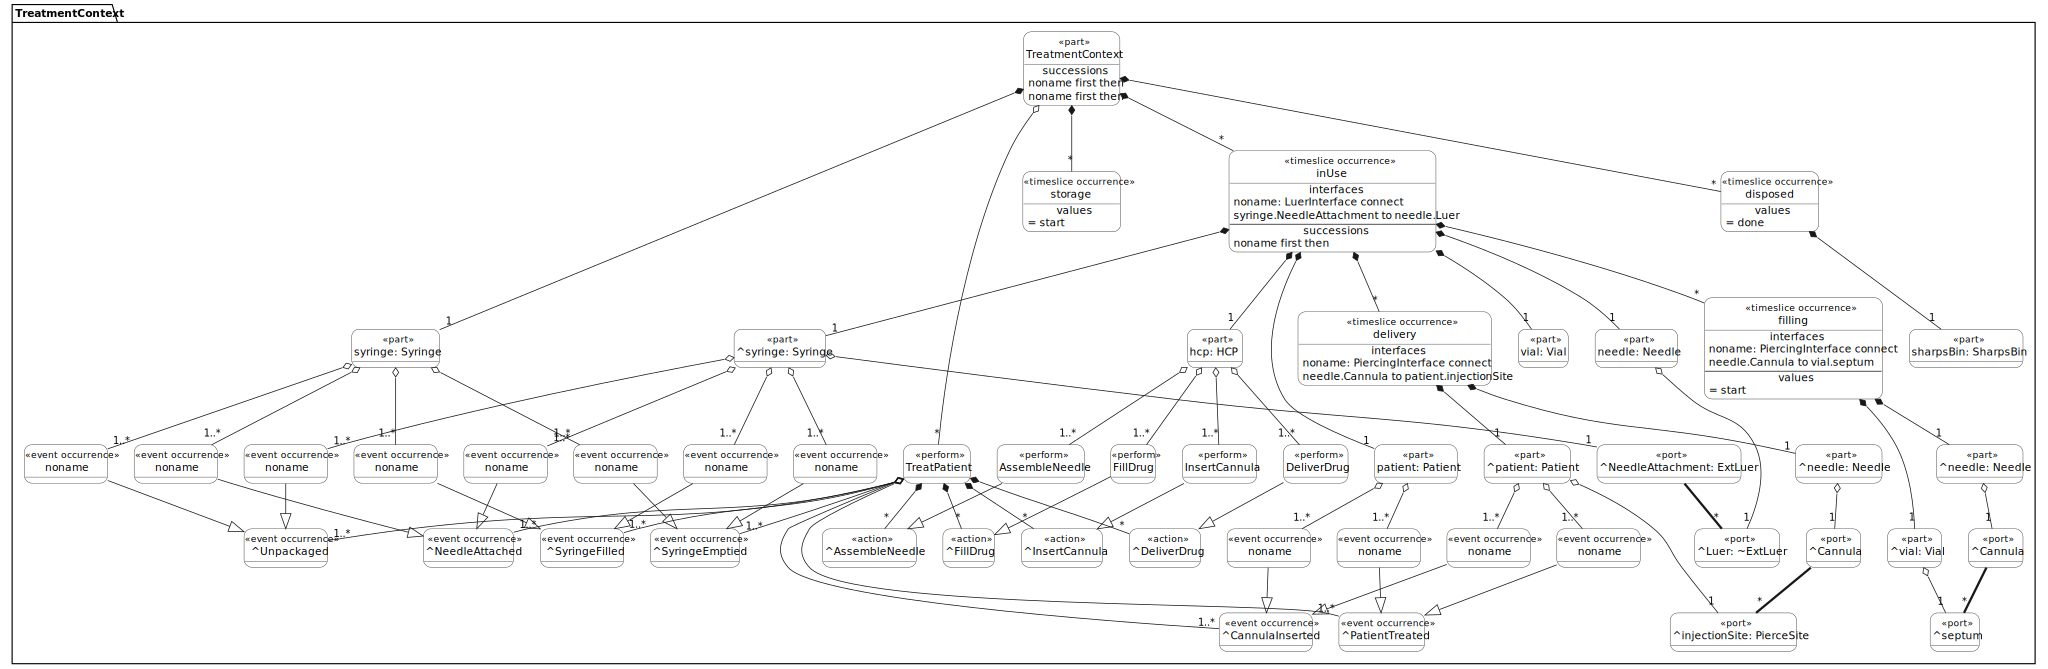

In [71]:
%viz --view=tree SyringeSystem::TreatmentContext

In [9]:
%viz -h

Usage: %viz [--view=<VIEW>] [--style=<STYLE>...] <NAME> [<NAME>...]

Visualize model elements of <NAME>(s). <NAME>s must be fully qualified.

<VIEW> is case insensitive and possible candidates are:
   DEFAULT		Automatically choose an appropriate view from the given model element names
   TREE			Show a tree-structural view, like a Block Definition Diagram (BDD)
   INTERCONNECTION	Show an interconnection view, like an Internal Block Diagram (IBD)
   STATE		Show state machines
   ACTION		Show actions like an activity diagram
   SEQUENCE		Show events and messages in a sequence diagram
   MIXED		Show multiple views

<STYLE> is also case insensitive. Multiple --style options are allowed.  The possible style names are:
  DEFAULT		Standard B&&W
  STDCOLOR		Standard style with colors
  PLANTUML		PlantUML Style
  TB			Top-to-Bottom orientation
  LR			Left-to-Right orientation
  POLYLINE		Polyline style
  ORTHOLINE		Orthogonal line style
  SHOWLIB		Show elements of the standard libraries
  SHOWIN

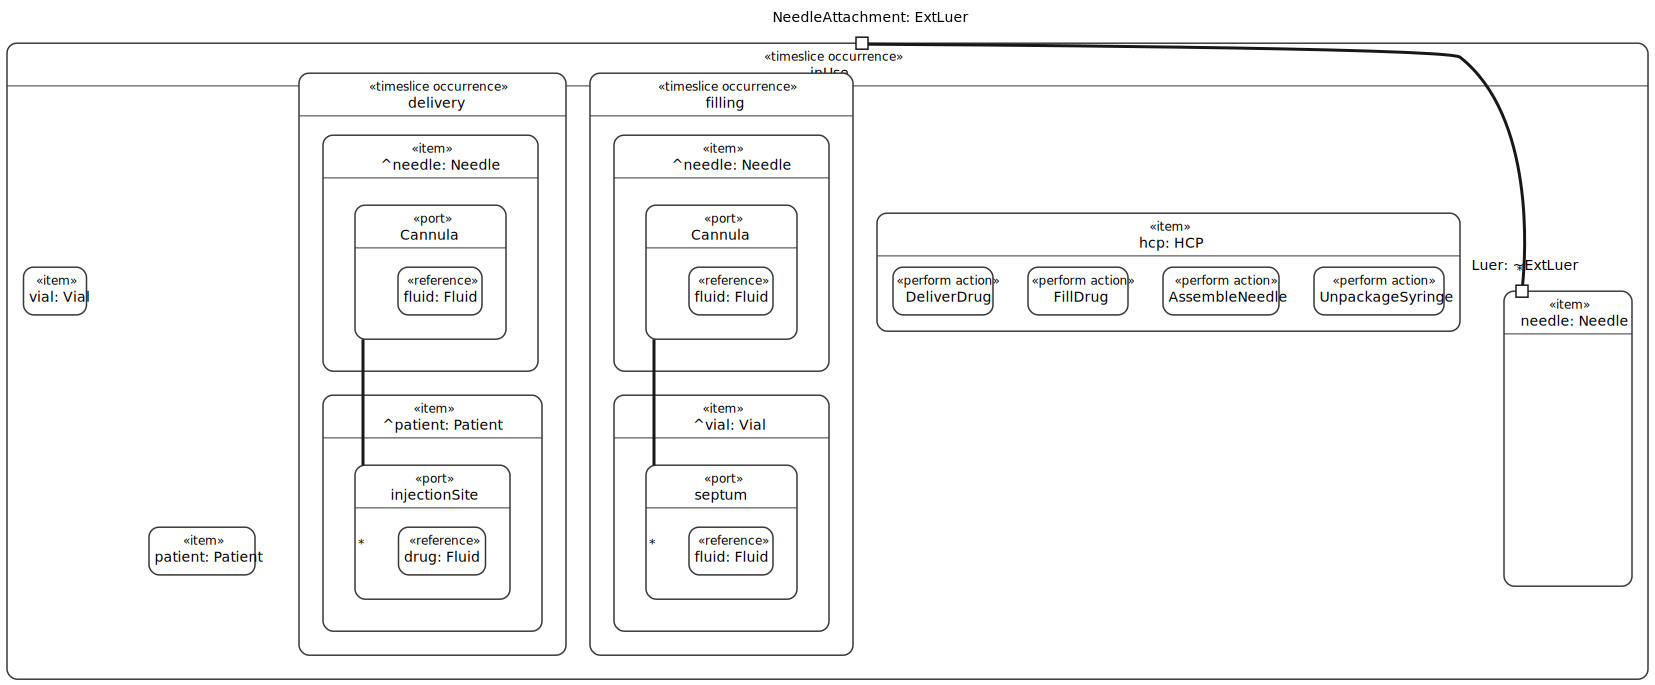

In [18]:
%viz --view=interconnection SyringeSystem::Structure::syringe::inUse

In [20]:
package 'Event Occurrence Example' {	
	part def Driver;
	part def CruiseController;
	part def Speedometer;
	part def Engine;
	part def Vehicle;
	
	part driver : Driver {
		event occurrence setSpeedSent;
	}
	
	part vehicle : Vehicle {
	
		part cruiseController : CruiseController {
			event occurrence setSpeedReceived;
			then event occurrence sensedSpeedReceived;		
			then event occurrence fuelCommandSent;
		}
		
		part speedometer : Speedometer {
			event occurrence sensedSpeedSent;
		}
		
		part engine : Engine {
			event occurrence fuelCommandReceived;
		}
	
	}
}

Package Event Occurrence Example (b52c09ff-1c9b-4abe-9cba-67ef921ac8fa)


In [21]:
package 'Interaction Example-1' {
	import 'Event Occurrence Example'::*;
	
	item def SetSpeed;
	item def SensedSpeed;
	item def FuelCommand;
	
	occurrence def CruiseControlInteraction {		
		ref part :>> driver;		
		ref part :>> vehicle;
		
		message setSpeedMessage of SetSpeed 
			from driver.setSpeedSent to vehicle.cruiseController.setSpeedReceived;
			
		message sensedSpeedMessage of SensedSpeed 
			from vehicle.speedometer.sensedSpeedSent to vehicle.cruiseController.sensedSpeedReceived;
			
		message fuelCommandMessage of FuelCommand 
			from vehicle.cruiseController.fuelCommandSent to vehicle.engine.fuelCommandReceived;
		
		first setSpeedMessage then sensedSpeedMessage;
	}
}

Package Interaction Example-1 (5959b608-e78d-4eb1-9f51-2b0089c43c72)


In [22]:
package 'Interaction Realization-1' {
	import 'Interaction Example-1'::*;
	
	part driver_a : Driver {
		action driverBehavior {
			action sendSetSpeed send SetSpeed() to vehicle_a;
		}
	}
	
	part vehicle_a : Vehicle {
		part cruiseController_a : CruiseController {
			action controllerBehavior {
				action receiveSetSpeed accept SetSpeed via vehicle_a;
				then action receiveSensedSpeed accept SensedSpeed via cruiseController_a;
				then action sendFuelCommand send FuelCommand() to engine_a;
			}
		}
		
		part speedometer_a : Speedometer {
			action speedometerBehavior {
				action sendSensedSpeed send SensedSpeed() to cruiseController_a;
			}
		}
		
		part engine_a : Engine {
			action engineBehavior {
				action receiveFuelCommand accept FuelCommand via engine_a;
			}
		}
	}
	
	occurrence cruiseControlInteraction_a : CruiseControlInteraction {
		part :>> driver :>> driver_a {
			event driverBehavior.sendSetSpeed[1] :>> setSpeedSent;
		}
		
		part :>> vehicle :>> vehicle_a {
			part :>> cruiseController :>> cruiseController_a {
				event controllerBehavior.receiveSetSpeed[1] :>> setSpeedReceived;
				event controllerBehavior.receiveSensedSpeed[1] :>> sensedSpeedReceived;
				event controllerBehavior.sendFuelCommand[1] :>> fuelCommandSent;
			}
			part :>> speedometer :>> speedometer_a {
				event speedometerBehavior.sendSensedSpeed[1] :>> sensedSpeedSent;
			}
			part :>> engine :>> engine_a {
				event engineBehavior.receiveFuelCommand[1] :>> fuelCommandReceived;
			}
		}
		
		message :> driver_a.driverBehavior.sendSetSpeed.sentMessage :>> setSpeedMessage;
		message :> vehicle_a.speedometer_a.speedometerBehavior.sendSensedSpeed.sentMessage :>> sensedSpeedMessage;
		message :> vehicle_a.cruiseController_a.controllerBehavior.sendFuelCommand.sentMessage :>> fuelCommandMessage;
	}
}

Package Interaction Realization-1 (9b90d620-6f57-4bf3-bd27-6ee211a978cb)


In [24]:
part driver_a : Driver {
    perform action driverBehavior{
        send SetSpeed () to vehicle_a;
    }
}
part vehicle_a : Vehicle {
    part cruiseController_a : CruiseController{
        perform action controllerBehavior{
            accept SetSpeed via vehicle_a;
            then accept SensedSpeed via cruiseController_a;
            then send FuelCommand () to engine_a;
        }
    }
    part speedometer_a : Speedometer{
        perform action speedometerBehavior{
            send SensedSpeed () to cruiseController_a;
        }
    }
    part engine_a : Engine{
        perform action engineBehavior{
            accept FuelCommand via engine_a;
        }
    }
}

ERROR:Couldn't resolve reference to Type 'Driver'. (24.sysml line : 1 column : 17)
ERROR:Couldn't resolve reference to Type 'SetSpeed'. (24.sysml line : 3 column : 14)
ERROR:Couldn't resolve reference to Type 'Vehicle'. (24.sysml line : 6 column : 18)
ERROR:Couldn't resolve reference to Type 'CruiseController'. (24.sysml line : 7 column : 31)
ERROR:Couldn't resolve reference to Type 'SetSpeed'. (24.sysml line : 9 column : 20)
ERROR:Couldn't resolve reference to Type 'SensedSpeed'. (24.sysml line : 10 column : 25)
ERROR:Couldn't resolve reference to Type 'FuelCommand'. (24.sysml line : 11 column : 23)
ERROR:Couldn't resolve reference to Type 'Engine'. (24.sysml line : 19 column : 21)
ERROR:Couldn't resolve reference to Type 'Speedometer'. (24.sysml line : 14 column : 26)
ERROR:Couldn't resolve reference to Type 'SensedSpeed'. (24.sysml line : 16 column : 18)
ERROR:Couldn't resolve reference to Type 'FuelCommand'. (24.sysml line : 21 column : 20)
ERROR:A part must be typed by item defini

In [46]:
package Scenario_1o{
    item def VehicleStart;
    item def EngineStatus;
    action startVehicle1{
        event occurrence doorClosed;
        event occurrence driverReady;
        first doorClosed then driverReady;
        first driverReady then turnVehicleOn;
        action turnVehicleOn send vs via source{ 
            in vs:VehicleStart;
            in source default self;
        }
        action trigger1 accept vs:VehicleStart;
        flow of VehicleStart from trigger1.vs to startEngine.vs;
        action startEngine{
            in item vs:VehicleStart; 
            out item es:EngineStatus;
        }
        flow of EngineStatus from startEngine.es to sendStatus.es;
        action sendStatus send es via source{
            in es:EngineStatus;
            in source default self;
        }
        action trigger2 accept es:EngineStatus;
        message of VehicleStart from turnVehicleOn to trigger1; 
        message of es:EngineStatus from sendStatus to trigger2;
    }
    part def Driver{
        port p1;
        port p2;
    }
    part def Vehicle{
        port p1;
    }
    part part0{
        perform action startVehicle:>startVehicle1{
            action :>> turnVehicleOn send vs via source{
        in :>> source = driver.p1;
    }
            action :>> trigger1 accept vs:VehicleStart via vehicle.p1;
            action :>> sendStatus send es via source{
        in es:EngineStatus;
        in :>> source = vehicle.p1;
    }
            action :>> trigger2 accept es:EngineStatus via vehicle.p1;
        }
        part driver : Driver {
            perform startVehicle.turnVehicleOn;
            perform startVehicle.trigger2;
            event startVehicle.driverReady;
        }
        part vehicle : Vehicle {
        perform startVehicle.trigger1;
        perform startVehicle.startEngine;
        perform startVehicle.sendStatus;
        event startVehicle.doorClosed;
        }
        interface driver.p1 to vehicle.p1;
        interface driver.p2 to vehicle.p1;
    }
}

Package Scenario_1o (1b5dab12-7913-4b31-839f-2daff28082fc)


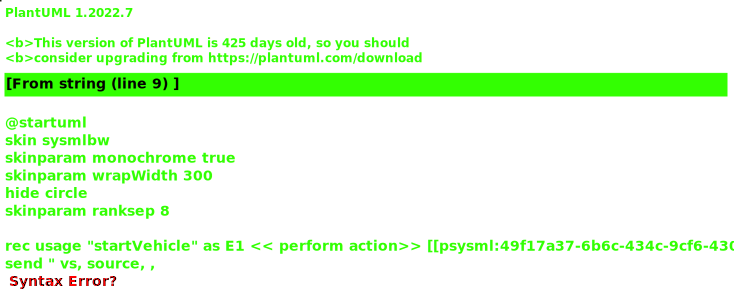

In [65]:
%viz --view=action Scenario_1o::part0